# Defining spatially varying index using custom medium

When a regular `Tidy3D` [Medium](../_autosummary/tidy3d.Medium.html) is assigned to a [Structure](../_autosummary/tidy3d.Structure.html), the refractive index is homogeneous within the geometry. In some cases, such as gradient-index optics component simulations, a spatially varying refractive index distribution is desirable. In principle, this can be achieved by manually dividing the [Structure](../_autosummary/tidy3d.Structure.html) into smaller sub-components and assigning a refractive index value to each component according to the spatial distribution. However, this process can be tedious and error-prone. Fortunately, `Tidy3D`'s [CustomMedium](../_autosummary/tidy3d.CustomMedium.html) can help you achieve this result very conveniently.

In this tutorial, we illustrate how to define structures made of [CustomMedium](../_autosummary/tidy3d.CustomMedium.html) that allow for a customized refractive index spatial profile. An example is an ideal gradient index lens that has flat surfaces but a parabolic distribution of refractive index. The simulation result allows us to examine the focusing capability of the lens. 

<img src="img/graded_index_lens.png" width="300">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web
from tidy3d import ScalarFieldDataArray
from tidy3d import PermittivityDataset


The lens is designed to work at 1 $\mu m$ wavelength.

In [2]:
lda0 = 1  # central wavelength

freq0 = td.C_0 / lda0  # central frequency


## Custom medium setup

With [CustomMedium](../_autosummary/tidy3d.CustomMedium.html), one can customize the spatial profile of refractive index inside a structure. The spatial profile is defined with [ScalarFieldDataAarray](../_autosummary/tidy3d.ScalarFieldDataArray.html) where we provide scalar data such as refractive index and labeled coordinates. Below, let's see how to define a flat lens whose index of refraction follows $n(r)=n_0(1-Ar^2)$, where $r$ is the radial distance to the $z$-axis. In this particular example, we study a lens of 20 $\mu m$ radius and 10 $\mu m$ thickness.

First, we define the spatial and frequency grids. The refractive index is invariant alone $z$-axis, and varies in the $x$-$y$ plane. For the uniform $z$-axis, we only need to supply one grid point since [CustomMedium](../_autosummary/tidy3d.CustomMedium.html) will automatically generate uniform profiles along the axis where a single grid point is supplied. In the $x$ and $y$ dimensions, we set 100 grid points to fully resolve the refractive index variation. Finally, for the frequency grid, we only support dispersiveless medium at the moment, so we just define the frequency of interest.

In [3]:
Nx, Ny, Nz, Nf = 100, 100, 1, 1  # number of grid points along each dimension

r = 20  # radius of the lens, unit: micron
t = 10  # thickness of the lens, unit: micron

# The coordinate for the refractive index data that includes x, y, z, and frequency
# Note: when only one coordinate is supplied along an axis, it means the medium is uniform along this axis.
X = np.linspace(-r, r, Nx)  # x grid
Y = np.linspace(-r, r, Ny)  # y grid
Z = [0]  # z grid
freqs = [freq0]  # frequency grid


Next, we define a 4-dimensional array that stores the refractive index.

In [4]:
# define coordinate array
x_mesh, y_mesh, z_mesh, freq_mesh = np.meshgrid(X, Y, Z, freqs, indexing="ij")
r_mesh = np.sqrt(x_mesh**2 + y_mesh**2)  # radial distance

# index of refraction array
# assign the refractive index value to the array according to the desired profile
n_data = np.ones((Nx, Ny, Nz, Nf))
n0 = 2
A = 1e-3
n_data[r_mesh <= r] = n0 * (1 - A * r_mesh[r_mesh <= r] ** 2)


Finally, we convert the numpy array to a [ScalarFieldDataArray](../_autosummary/tidy3d.ScalarFieldDataArray.html) that labels the coordinate.

In [5]:
# convert to dataset array
n_dataset = ScalarFieldDataArray(n_data, coords=dict(x=X, y=Y, z=Z, f=freqs))


### Defining CustomMedium in three ways
Here, we will illustrate defining custom medium in three different ways:
1. Using classmethod [td.CustomMedium.from_nk](../_autosummary/tidy3d.CustomMedium.html#tidy3d.CustomMedium.from_nk) when refractive index and extinction coefficients are readily available.
2. Using classmethod [td.CustomMedium.from_eps_raw](../_autosummary/tidy3d.CustomMedium.html#tidy3d.CustomMedium.from_eps_raw) to supply complex-valued permittivity data.
3. Define permittivity for each component separately via [PermittivityDataset](../_autosummary/tidy3d.PermittivityDataset.html) to be supplied to `td.CustomMedium`.

In any of the three ways, you can optionally define how the permittivity is **interpolated** to Yee-grid with `interp_method` that can take the value of "linear" or "nearest". The default value is "nearest". If the custom medium is applied to a geometry larger than the custom medium's grid range, **extrapolation** is automatically applied for Yee grids outside the supplied coordinate region. When the extrapolated value is smaller (greater) than the minimal (maximal) of the supplied data, the extrapolated value will take the minimal (maximal) of the supplied data.

In [6]:
## Three equivalent ways of defining custom medium for the lens

# define custom medium with n/k data
mat_custom1 = td.CustomMedium.from_nk(n_dataset, interp_method="nearest")

# define custom medium with permittivity data
eps_dataset = ScalarFieldDataArray(n_dataset**2, coords=dict(x=X, y=Y, z=Z, f=freqs))
mat_custom2 = td.CustomMedium.from_eps_raw(eps_dataset, interp_method="nearest")

# define each component of permittivity via "PermittivityDataset"
eps_xyz_dataset = PermittivityDataset(
    eps_xx=eps_dataset, eps_yy=eps_dataset, eps_zz=eps_dataset
)
mat_custom3 = td.CustomMedium(eps_dataset=eps_xyz_dataset, interp_method="nearest")


## Simulation setup
### Define Lens Structure 

In [7]:
# define the lens structure as a box
lens = td.Structure(
    geometry=td.Box(center=(0, 0, t / 2), size=(td.inf, td.inf, t)), medium=mat_custom1
)


### Define a Source and Monitor

In [8]:
# define a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -lda0),
    direction="+",
    pol_angle=0,
)


# define a field monitor in the xz plane at y=0
monitor_field_xz = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, td.inf], freqs=[freq0], name="field_xz"
)


### Define a Simulation 

In [9]:
# simulation domain size
Lx, Ly, Lz = 2 * r, 2 * r, 5 * t
sim_size = (Lx, Ly, Lz)

run_time = 2e-12  # simulation run time

# define simulation
sim = td.Simulation(
    center=(0, 0, Lz / 2 - lda0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=10, wavelength=lda0),
    structures=[lens],
    sources=[plane_wave],
    monitors=[monitor_field_xz],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),  # pml is applied in all boundaries
    symmetry=(
        -1,
        1,
        0,
    ),  # symmetry is used such that only a quarter of the structure needs to be modeled.
)


### Visualize the Simulation and Gradient Index Distribution 

We can use the `plot_eps` method of [Simulation](../_autosummary/tidy3d.Simulation.html) to visualize the simulation setup as well as the permittivity distribution. 

First, plot the $yz$ plane at $x$=0.

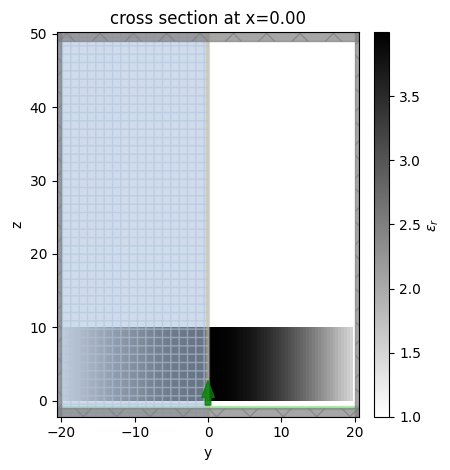

In [10]:
sim.plot_eps(x=0)
plt.show()


Similarly, plot the $xy$ plane at $z$=0. The spatially varying permittivity is clearly observed.

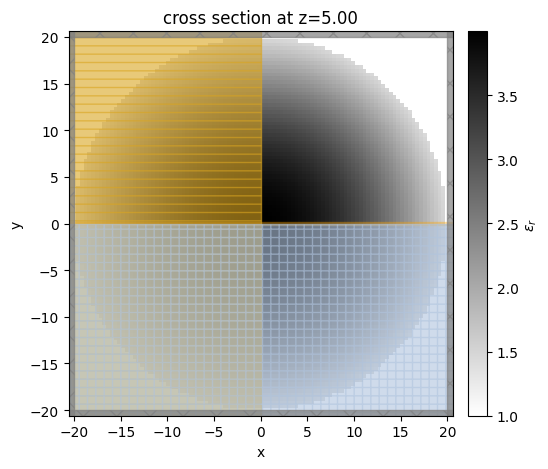

In [11]:
sim.plot_eps(z=t / 2)
plt.show()


### Submit Simulation Job 

Submit the simulation job to the server.

In [12]:
sim_data = web.run(
    sim,
    task_name="gradient_index_lens",
    path="data/simulation.hdf5",
    verbose=True,
)


[13:35:43] Created task 'gradient_index_lens' with task_id                      ]8;id=743785;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=39906;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#139\139]8;;\
           'fdve-d7c066cb-d005-4355-bd29-94e161114eb5v1'.                                    

Output()

Output()

[13:35:45] status = queued                                                      ]8;id=623250;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=255762;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#269\269]8;;\

Output()

[13:36:02] status = preprocess                                                  ]8;id=828459;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=29240;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#263\263]8;;\

[13:36:07] Maximum FlexCredit cost: 0.676. Use 'web.real_cost(task_id)' to get    ]8;id=365603;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=140425;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#286\286]8;;\
           the billed FlexCredit cost after a simulation run.                                  

           starting up solver                                                   ]8;id=499223;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=277262;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#290\290]8;;\

[13:36:08] running solver                                                       ]8;id=906208;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=121823;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#300\300]8;;\

Output()

[13:41:41] early shutoff detected, exiting.                                     ]8;id=323882;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=543331;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#313\313]8;;\

           status = postprocess                                                 ]8;id=161258;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=732865;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#330\330]8;;\

Output()

[13:41:53] status = success                                                     ]8;id=248651;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=542;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#337\337]8;;\

Output()

[13:41:57] loading SimulationData from data/simulation.hdf5                     ]8;id=74061;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=182664;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#512\512]8;;\

## Result Visualization 

After the simulation is complete, we can inspect the focusing capability of the gradient-index lens by plotting the field distributions. First, plot $E_x$ in the $xz$ plane at $y=0$.

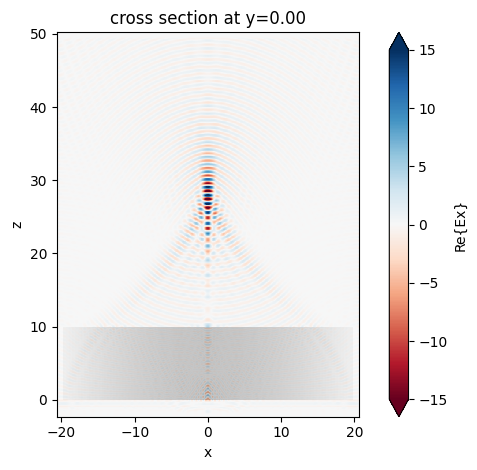

In [13]:
sim_data.plot_field("field_xz", "Ex", vmin=-15, vmax=15)
plt.show()


The focus is better visualized by plotting the field intensity. A strong focus about 17 $\mu m$ from the front surface of the lens is observed.

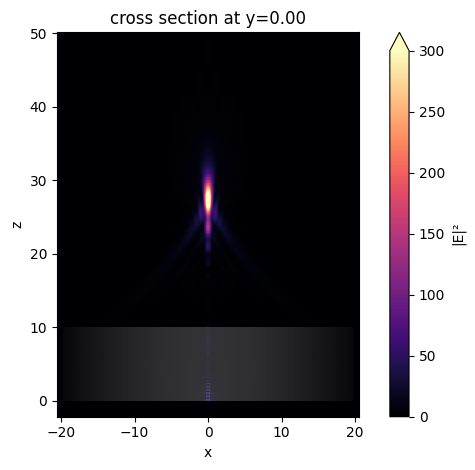

In [14]:
sim_data.plot_field("field_xz", "E", "abs^2", vmin=0, vmax=300)
plt.show()


## Notes:
* Subpixel averaging is turned off on the surface and inside the structure made of custom medium. Therefore, it is generally recommended to use a finer grid to resolve the fields around curved surfaces. 

* Only non-dispersive custom medium is supported in this release. Dispersive custom medium support is expected in the future.